In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, NamedTuple

In [16]:
results = pd.read_csv('../results/processed_data.csv')
results.head()

,timestamp,user_id,day,quiz_id,image_index,illusion_filename,user_answer,response_time,speed_group,display_time,correct_answer,line_length1,line_length2,actual_difference,arrow_length,angle,arrow_color,is_control,is_correct
0,2024-11-05 01:34:15,Haleygundie,1,1,0,muller_lyer_day1_illusion13.svg,Left,7.209,Group 1 - Slow,5.0,Right,185,200,-15,20,36,black,False,False
1,2024-11-05 01:34:22,Haleygundie,1,1,1,muller_lyer_day1_illusion27.svg,Same length,5.427,Group 1 - Slow,5.0,Same length,200,200,0,20,36,red,False,True
2,2024-11-05 01:34:27,Haleygundie,1,1,2,muller_lyer_day1_illusion46.svg,Left,4.179,Group 1 - Slow,5.0,Left,205,180,25,20,36,red,False,True
3,2024-11-05 01:34:35,Haleygundie,1,1,3,muller_lyer_day1_illusion37.svg,Right,6.192,Group 1 - Slow,5.0,Right,185,200,-15,20,36,red,False,True
4,2024-11-05 01:34:41,Haleygundie,1,1,4,muller_lyer_day1_illusion42.svg,Right,5.236,Group 1 - Slow,5.0,Right,185,220,-35,20,36,red,False,True


In [17]:
class ParticipantStats(NamedTuple):
    user_id: str
    total_trials: int
    correct_black: int
    total_black: int
    correct_red: int
    total_red: int
    avg_rt_fast: float
    avg_rt_slow: float
    correct_fast: int
    total_fast: int
    correct_slow: int
    total_slow: int

In [18]:
def calculate_participant_stats(df: pd.DataFrame) -> Dict[str, ParticipantStats]:
    """Calculate statistics for each participant."""
    stats = {}
    
    for user_id in df['user_id'].unique():
        user_data = df[df['user_id'] == user_id]
        
        # Calculate color-based stats
        black_trials = user_data[user_data['arrow_color'] == 'black']
        red_trials = user_data[user_data['arrow_color'] == 'red']
        
        # Calculate speed-based stats
        fast_trials = user_data[user_data['speed_group'].str.contains('Fast')]
        slow_trials = user_data[user_data['speed_group'].str.contains('Slow')]
        
        stats[user_id] = ParticipantStats(
            user_id=user_id,
            total_trials=len(user_data),
            correct_black=len(black_trials[black_trials['is_correct']]),
            total_black=len(black_trials),
            correct_red=len(red_trials[red_trials['is_correct']]),
            total_red=len(red_trials),
            avg_rt_fast=fast_trials['response_time'].mean(),
            avg_rt_slow=slow_trials['response_time'].mean(),
            correct_fast=len(fast_trials[fast_trials['is_correct']]),
            total_fast=len(fast_trials),
            correct_slow=len(slow_trials[slow_trials['is_correct']]),
            total_slow=len(slow_trials)
        )
    
    return stats

In [19]:
def create_comparison_visualization(stats: Dict[str, ParticipantStats]) -> None:
    """Create a visualization comparing fast vs slow performance."""
    # Prepare data for plotting
    plot_data = []
    
    for stat in stats.values():
        # Only include data points where trials exist
        if stat.total_fast > 0:
            plot_data.append({
                'user_id': stat.user_id,
                'Speed': 'Fast',
                'Accuracy (%)': (stat.correct_fast / stat.total_fast * 100)
            })
        if stat.total_slow > 0:
            plot_data.append({
                'user_id': stat.user_id,
                'Speed': 'Slow',
                'Accuracy (%)': (stat.correct_slow / stat.total_slow * 100)
            })
    
    plot_data = pd.DataFrame(plot_data)
    
    if len(plot_data) == 0:
        print("Warning: No data available for visualization")
        return
    
    # Create the visualization
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    # Create box plot with individual points
    sns.boxplot(data=plot_data, x='Speed', y='Accuracy (%)', color='lightgray')
    sns.swarmplot(data=plot_data, x='Speed', y='Accuracy (%)', color='darkblue', size=8)
    
    # Customize the plot
    plt.title('Accuracy Comparison: Fast vs Slow Display Times', pad=20)
    plt.ylabel('Accuracy (%)')
    
    # Add mean lines for each condition
    means = plot_data.groupby('Speed')['Accuracy (%)'].mean()
    for i, speed in enumerate(means.index):
        plt.hlines(means[speed], i-0.3, i+0.3, color='red', linestyles='dashed', label='Mean' if i == 0 else '')
    
    plt.legend()
    plt.tight_layout()

In [20]:
def create_accuracy_trend_visualization(df: pd.DataFrame) -> None:
    """Create a line plot showing accuracy trends over days for each participant, separated by speed."""
    # Calculate daily accuracy for each participant and speed condition
    daily_accuracy = df.groupby(['user_id', 'day', 'speed_group']).agg({
        'is_correct': ['count', 'sum']
    }).reset_index()
    
    # Calculate accuracy percentage
    daily_accuracy.columns = ['user_id', 'day', 'speed_group', 'total_trials', 'correct_trials']
    daily_accuracy['accuracy'] = (daily_accuracy['correct_trials'] / 
                                daily_accuracy['total_trials'] * 100)
    
    # Simplify speed group names
    daily_accuracy['speed'] = daily_accuracy['speed_group'].apply(
        lambda x: 'Fast' if 'Fast' in x else 'Slow'
    )
    
    # Create the visualization
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    # Get unique users for color assignment
    users = sorted(df['user_id'].unique())
    colors = sns.color_palette("husl", n_colors=len(users))
    
    # Create line plot for each user and speed condition
    for i, user in enumerate(users):
        user_data = daily_accuracy[daily_accuracy['user_id'] == user]
        
        # Plot fast condition (solid line)
        fast_data = user_data[user_data['speed'] == 'Fast']
        if not fast_data.empty:
            plt.plot(fast_data['day'], fast_data['accuracy'], 
                    color=colors[i], linestyle='-', marker='o',
                    label=f'{user} (Fast)', markersize=8)
        
        # Plot slow condition (dashed line)
        slow_data = user_data[user_data['speed'] == 'Slow']
        if not slow_data.empty:
            plt.plot(slow_data['day'], slow_data['accuracy'], 
                    color=colors[i], linestyle='--', marker='s',
                    label=f'{user} (Slow)', markersize=8)
    
    # Customize the plot
    plt.title('Accuracy Trends Over Time by Participant and Speed', pad=20)
    plt.xlabel('Day')
    plt.ylabel('Accuracy (%)')
    
    # Adjust x-axis to show only integer days
    plt.xticks(sorted(daily_accuracy['day'].unique()))
    
    # Add legend with a title
    plt.legend(title='Participant ID (Speed)',
              bbox_to_anchor=(1.05, 1), 
              loc='upper left',
              borderaxespad=0)
    
    # Ensure no labels are cut off
    plt.tight_layout()

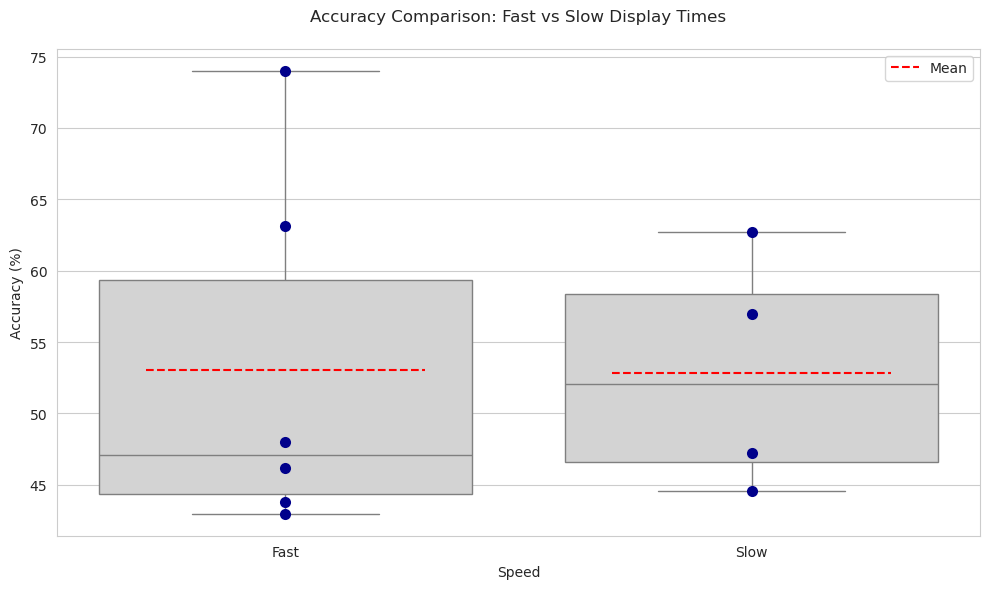

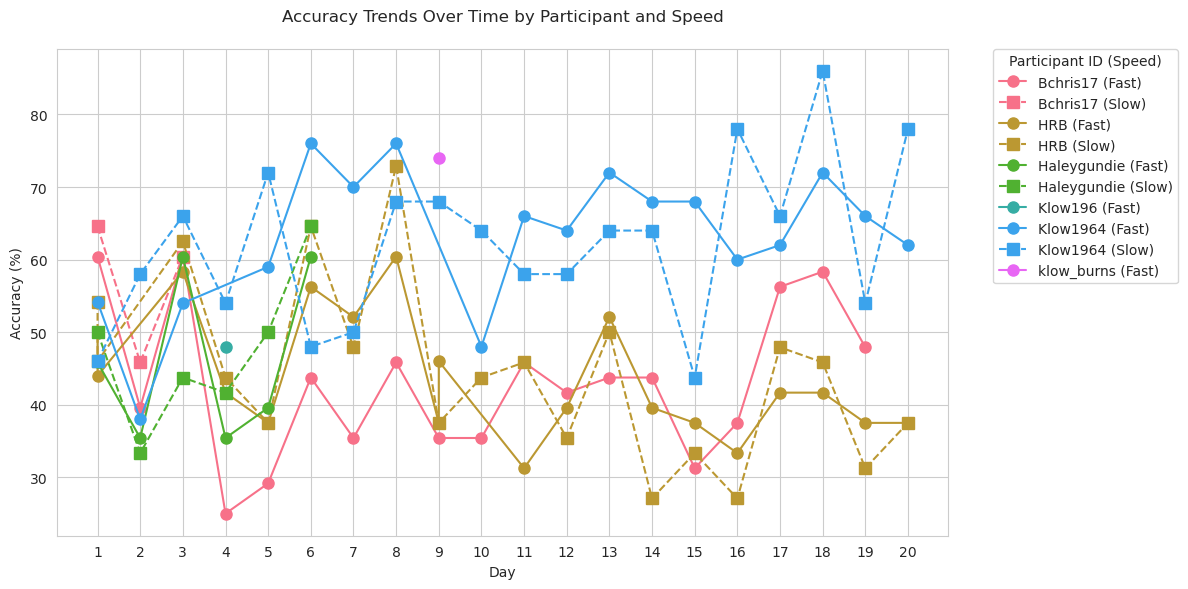

In [21]:
# Calculate statistics for all participants
participant_stats = calculate_participant_stats(results)

# Create visualizations
create_comparison_visualization(participant_stats)
plt.show()

create_accuracy_trend_visualization(results)
plt.show()